## DataHack by IIT Guwahati
## 234102304 - DILLIP S - s.dillip@iitg.ac.in 
## Summer Analytics Hackathon

Problem description


The goal is to predict how likely individuals are to receive their xyz and seasonal flu
vaccines. Specifically, you'll be predicting two probabilities: one for xyz_vaccine and
one for seasonal_vaccine.

#### Importing necessary libraries

In [18]:
#Importing necessary libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#### Loading pre-processed train and test features

In [19]:
# Load the pre-processed train dataset features
train_features = pd.read_csv('pre_processed_train_features.csv')


In [20]:
# Load the pre-processed test dataset features
test_data_features = pd.read_csv('pre_processed_test_set_features.csv')

In [21]:
# Load the training dataset labels
train_labels = pd.read_csv('training_set_labels.csv')

#### Converting Categorical variables

In [22]:
# Separate features and target variables in training data
features = train_features.drop(columns=['respondent_id'])
target = train_labels[['xyz_vaccine', 'seasonal_vaccine']]

# Identify categorical and numerical columns
categorical_cols = features.select_dtypes(include=['object']).columns
numerical_cols = features.select_dtypes(exclude=['object']).columns

# Apply one-hot encoding to categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical = encoder.fit_transform(features[categorical_cols])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_cols))

# Combine encoded categorical features with numerical features
features_encoded = pd.concat([features[numerical_cols].reset_index(drop=True), encoded_categorical_df.reset_index(drop=True)], axis=1)

# Standardize numerical features
scaler = StandardScaler()
features_encoded[numerical_cols] = scaler.fit_transform(features_encoded[numerical_cols])

In [23]:
# Apply same transformations to test data

test_encoded_categorical = encoder.transform(test_data_features[categorical_cols])
test_encoded_categorical_df = pd.DataFrame(test_encoded_categorical, columns=encoder.get_feature_names_out(categorical_cols))
test_features_encoded = pd.concat([test_data_features[numerical_cols].reset_index(drop=True), test_encoded_categorical_df.reset_index(drop=True)], axis=1)
test_features_encoded[numerical_cols] = scaler.transform(test_features_encoded[numerical_cols])


In [24]:
# Train-test split for model evaluation
X_train, X_val, y_train, y_val = train_test_split(features_encoded, target, test_size=0.3, random_state=23)

## Model Fitting and ROC AUC calculation

In [25]:
models = {}
predictions = {}
for target_col in ['xyz_vaccine', 'seasonal_vaccine']:
    model = SVC(kernel='linear', probability= True)
    model.fit(X_train, y_train[target_col])
    y_val_pred = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val[target_col], y_val_pred)
    print(f'ROC AUC for {target_col}: {roc_auc}')
    models[target_col] = model
    predictions[target_col] = model.predict_proba(test_features_encoded)[:, 1]

ROC AUC for xyz_vaccine: 0.8290845370391644
ROC AUC for seasonal_vaccine: 0.8546326979639971


## Plotting Confusion Matrix

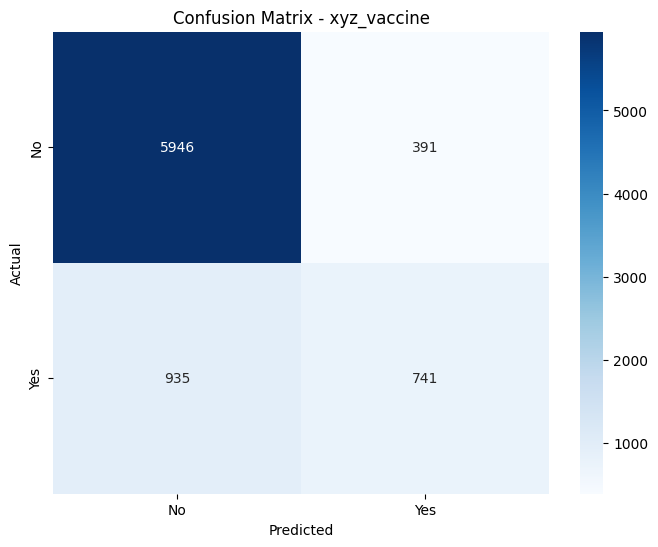

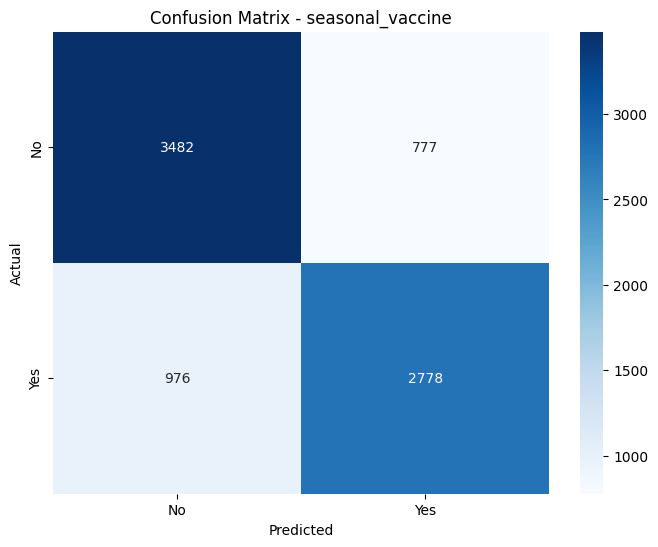

In [26]:
# Define a function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

# Plot confusion matrices for each target variable
for target_col in ['xyz_vaccine', 'seasonal_vaccine']:
    y_val_pred_prob = models[target_col].predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_pred_prob >= 0.5).astype(int)
    plot_confusion_matrix(y_val[target_col], y_val_pred, target_col)


## Plotting ROC curve

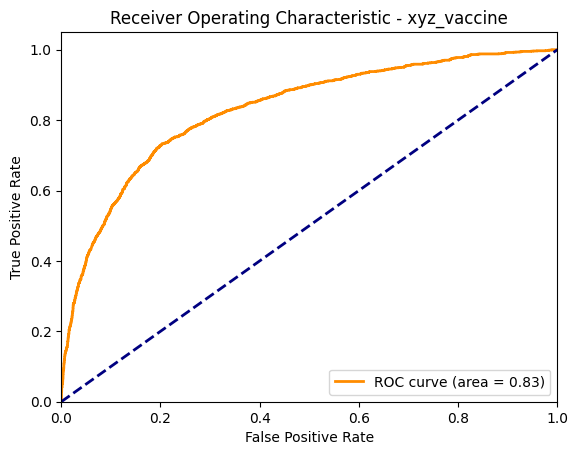

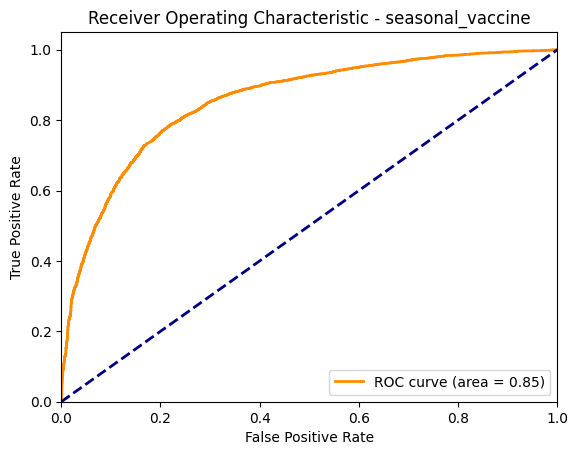

In [27]:
# Define a function to plot ROC curves
def plot_roc_curve(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curves for each target variable
for target_col in ['xyz_vaccine', 'seasonal_vaccine']:
    y_val_pred = models[target_col].predict_proba(X_val)[:, 1]
    plot_roc_curve(y_val[target_col], y_val_pred, target_col)


In [29]:
# Exporting submission
submission = test_data_features[['respondent_id']]
submission['xyz_vaccine'] = predictions['xyz_vaccine']
submission['seasonal_vaccine'] = predictions['seasonal_vaccine']

# Save submission file
submission.to_csv('submissionSVMLinear.csv', index=False)

C:\Users\dilli\AppData\Local\Temp\ipykernel_14636\624049828.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['xyz_vaccine'] = predictions['xyz_vaccine']
C:\Users\dilli\AppData\Local\Temp\ipykernel_14636\624049828.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['seasonal_vaccine'] = predictions['seasonal_vaccine']
